In [1]:
import pandas as pd
from bokeh.plotting import figure, output_file, show, curdoc
from bokeh.io import output_notebook
from bokeh.layouts import row, column
from bokeh.models import BoxSelectTool, LassoSelectTool, Spacer
from bokeh.models import LinearAxis, Range1d
import pymc3 as pm
import numpy as np
import theano
output_notebook()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import norm, multinomial
sns.set_style('white')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading BokehJS ...

The below dataset is the provided RDS file converted within R to csv. It is then loaded into pandas, a dataframe

In [2]:
Data = pd.read_csv("ConvertedData.csv", low_memory=False)

Selecting the relevant columns

In [3]:
Data = Data[['X', 'Y', 'Chemical', 'SampleDate', 'ValueOrHalfQL', 
              'Unit', 'Detected', 'FE_NAVCHAN_F', 'UpperDepth_cm', 
              'LowerDepth_cm', 'FE_Z2003Bathy_MLLW']]

Data = Data.rename(index=str, columns={"ValueOrHalfQL": "Concentration","FE_Z2003Bathy_MLLW": "SampleElevation", "FE_NAVCHAN_F": "InDredgedNavigationChannel"})

Data.head(3)

,X,Y,Chemical,SampleDate,Concentration,Unit,Detected,InDredgedNavigationChannel,UpperDepth_cm,LowerDepth_cm,SampleElevation
0,1274912.0,196501.0,"1,1,1,2-Tetrachloroethane",1998-08-18 23:00:00,1.30,ug/kg dw,No,N,0,10,-6.483755
1,1271882.0,198941.0,"1,1,1,2-Tetrachloroethane",1998-08-12 23:00:00,1.45,ug/kg dw,No,N,0,10,-14.540000
2,1273359.0,197554.0,"1,1,1,2-Tetrachloroethane",1998-08-19 23:00:00,1.15,ug/kg dw,No,N,0,10,-9.956525


Converting date strings to datetime objects

In [4]:
Data['SampleDate'] = pd.to_datetime(Data.copy()['SampleDate'])

Scaling the date and positions

In [5]:
MinDate = Data['SampleDate'].min()
MaxDate = Data['SampleDate'].max()
Data['SampleDate'] = (Data['SampleDate'] - MinDate)/(MaxDate-MinDate)

MinX = Data['X'].min()
MaxX = Data['X'].max()
Data['X'] = (Data['X'] - MinX)/(MaxX-MinX)

MinY = Data['Y'].min()
MaxY = Data['Y'].max()
Data['Y'] = (Data['Y'] - MinY)/(MaxY-MinY)

MinZ = Data['SampleElevation'].min()
MaxZ = Data['SampleElevation'].max()
Data['SampleElevation'] = (Data['SampleElevation'] - MinZ)/(MaxZ-MinZ)
print ("Min Z: ", MinZ, "Max Z: ", MaxZ)
print ("DeltaZ: ", MaxZ-MinZ)

Min Z:  -53.1800003051758 Max Z:  7.53000020980835
DeltaZ:  60.71000051498415


In [6]:
Data.head(3)

,X,Y,Chemical,SampleDate,Concentration,Unit,Detected,InDredgedNavigationChannel,UpperDepth_cm,LowerDepth_cm,SampleElevation
0,0.699776,0.315584,"1,1,1,2-Tetrachloroethane",0.411649,1.30,ug/kg dw,No,N,0,10,0.769169
1,0.465926,0.427881,"1,1,1,2-Tetrachloroethane",0.410801,1.45,ug/kg dw,No,N,0,10,0.636468
2,0.579918,0.364046,"1,1,1,2-Tetrachloroethane",0.411790,1.15,ug/kg dw,No,N,0,10,0.711966


We get rid of all NaN entries

In [7]:
Data = Data[np.isfinite(Data['Concentration'])]
Data = Data[np.isfinite(Data['SampleElevation'])]
Data = Data[np.isfinite(Data['SampleDate'])]

We next select the data with the relevant chemicals to this analysis. We also make sure that the measurement is reliable by choosing only those values where it was detected. We also normalize concentration values for each
chemical and check units

In [8]:
ArsenicData = Data.copy()[(Data['Chemical'] == 'Arsenic') & (Data['Detected'] == 'Yes')]
TotalPCBsData = Data.copy()[(Data['Chemical'] == 'Total PCBs') & (Data['Detected'] == 'Yes')]
TotalPAHsData = Data.copy()[(Data['Chemical'] == 'Total PAHs') & (Data['Detected'] == 'Yes')]


ArsenicData['Concentration'] = 1000.*ArsenicData['Concentration']
MinArsenicConc = ArsenicData['Concentration'].min()
MaxArsenicConc = ArsenicData['Concentration'].max()
ArsenicData['Concentration'] = (ArsenicData['Concentration']-MinArsenicConc)/(MaxArsenicConc-MinArsenicConc)
print (ArsenicData['Unit'].unique(), "Corrected!")

MinPCBConc = TotalPCBsData['Concentration'].min()
MaxPCBConc = TotalPCBsData['Concentration'].max()
TotalPCBsData['Concentration'] = (TotalPCBsData['Concentration']-MinPCBConc)/(MaxPCBConc-MinPCBConc)

print (TotalPCBsData['Unit'].unique())

MinPAHConc = TotalPAHsData['Concentration'].min()
MaxPAHConc = TotalPAHsData['Concentration'].max()
TotalPAHsData['Concentration'] = (TotalPAHsData['Concentration']-MinPAHConc)/(MaxPAHConc-MinPAHConc)

print (TotalPAHsData['Unit'].unique())

['mg/kg dw'] Corrected!
['ug/kg dw']
['ug/kg dw']


Next let's look at the distribution of height measurements for each chemical

In [9]:
bins = 100
hist, edges = np.histogram(ArsenicData['SampleElevation'], bins=bins)
hist1, edges1 = np.histogram(TotalPCBsData['SampleElevation'], bins=bins)
hist2, edges2 = np.histogram(TotalPAHsData['SampleElevation'], bins=bins)
hist3, edges3 = np.histogram(Data['SampleElevation'], bins=bins)

p = figure(title="Elevations of Arsenic Measurements", x_axis_label='Elevation', y_axis_label='Count')
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:])

p1 = figure(title="Elevations of PCB Measurements", x_axis_label='Elevation', y_axis_label='Count')
p1.quad(top=hist1, bottom=0, left=edges1[:-1], right=edges1[1:])

p2 = figure(title="Elevations of PAH Measurements", x_axis_label='Elevation', y_axis_label='Count')
p2.quad(top=hist2, bottom=0, left=edges2[:-1], right=edges2[1:])

p3 = figure(title="Elevations of All Measurements", x_axis_label='Elevation', y_axis_label='Count')
p3.quad(top=hist3, bottom=0, left=edges3[:-1], right=edges3[1:])

show(row(p, p1, p2, p3))

At first glance there are four gaussian regions for these measurements. However after doing a fit to the mixture of them(shown below) the data suggests that there are only three significant strata. Quoting the results below, the most probable scaled depths are 0.866, 0.380 and 0.672. The points belonging to each strata will be calculated below. 

In [10]:
ArsenicElevations = ArsenicData[ArsenicData['SampleElevation'] > 0.28]['SampleElevation'].values
PCBElevations = TotalPCBsData[TotalPCBsData['SampleElevation'] > 0.28]['SampleElevation'].values
PAHElevations = TotalPAHsData[TotalPAHsData['SampleElevation'] > 0.28]['SampleElevation'].values

TotalElevations = np.append(ArsenicElevations, PCBElevations)
TotalElevations = np.append(TotalElevations, PAHElevations)

NumberOfDists = 3
NumberOfDataPoints = ArsenicElevations.shape[0]

In [11]:
X = theano.shared(TotalElevations)

In [12]:
with pm.Model() as Model:
    #Probability that a point is in one of the four gaussians
    Probability = pm.Dirichlet('Probability', a=np.ones([NumberOfDists])/4., shape=NumberOfDists)

    #Category = pm.Categorical('category',p=Probability, shape=NumberOfDataPoints)
    
    GaussianMeans = pm.Normal('GaussianMeans', mu=np.array([0.88, .65, .4]), sd=10., shape=NumberOfDists)
    Sigmas = pm.HalfNormal('Sigmas', sd=10., shape=NumberOfDists)

    Likelihood = pm.NormalMixture("Obs", Probability, GaussianMeans, sd=Sigmas, observed=X)


In [13]:
try:
    Trace = pickle.load(open("Trace.p", "rb"))
except (OSError, IOError) as e:
    
    with Model:
        Trace = pm.sample(10000, cores = 3, njobs = 2, init = 'advi+adapt_diag', progressbar=True)

    pickle.dump(Trace, open("Trace.p", "wb"))
    


In [14]:
pm.summary(Trace, varnames = ['GaussianMeans', 'Sigmas', 'Probability'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
GaussianMeans__0,0.671875,0.003415,0.000040,0.665309,0.678672,9157.213481,0.999996
GaussianMeans__1,0.866486,0.002660,0.000028,0.861179,0.871563,8645.734468,0.999951
GaussianMeans__2,0.380348,0.003197,0.000026,0.374253,0.386714,12247.907537,0.999962
Sigmas__0,0.084555,0.003713,0.000042,0.077356,0.091932,8171.289493,0.999950
Sigmas__1,0.046968,0.001754,0.000018,0.043468,0.050370,9533.058021,1.000055
Sigmas__2,0.058572,0.002288,0.000017,0.054173,0.063103,13715.525822,0.999976
Probability__0,0.550627,0.017335,0.000203,0.516338,0.583639,7828.820322,0.999954
Probability__1,0.287032,0.014828,0.000179,0.257887,0.315579,7523.952798,0.999950
Probability__2,0.162342,0.006767,0.000056,0.149448,0.176170,17315.764458,0.999971


The mean elevations and one standard deviation around them are: 0.672 $\pm$ 0.084, 0.866 $\pm$ 0.047 and 0.380 $\pm$ 0.059 in our normalized system. This is a quick and dirty way of assigning strata to each sample but due to time, I will just use a random probability for the above distributions, weighted by the weights and then put in a multinomial sampler to calculate a random value. Then we will grab the index and call that the strata. Lower elevations will have increase in strata number.

In [15]:
def GetDistribution(z):
    Means = np.array([0.866486, 0.671875, 0.380348])
    Sigmas = np.array([0.046968, 0.084555, 0.058572])
    Weights = np.array([0.287032, 0.550627, 0.162342])
    
    Probabilities = [Weights*norm.cdf(x=Z, loc=Means, scale=Sigmas) for Z in z]
    Sample = [np.where(multinomial.rvs(n = 1, p = Prob) == 1)[0][0] for Prob in Probabilities]
    return np.asarray(Sample)


In [16]:
ArsenicStrata = GetDistribution(ArsenicData['SampleElevation'].values)
PCBStrata = GetDistribution(TotalPCBsData['SampleElevation'].values)
PAHStrata = GetDistribution(TotalPAHsData['SampleElevation'].values)

ArsenicData['Strata'] = ArsenicStrata
TotalPCBsData['Strata'] = PCBStrata
TotalPAHsData['Strata'] = PAHStrata

In [17]:
TotalPAHsData['Strata'].nunique()

3

Let's plot the x-y locations and the concentrations. On the concentrations plot, the width of the circles
designate time. The larger the circle, the most recent the time.

In [18]:
p = figure(x_axis_label='X', y_axis_label='Y', title = 'Measurement Locations for Arsenic')
p.y_range=Range1d(0., 1.)
Sizes = 15.*ArsenicData['SampleDate']
p.extra_y_ranges = {'Concentration': Range1d(start=0, end=1.)}
p.add_layout(LinearAxis(y_range_name="Concentration", axis_label="Concentration"), 'right')
p.scatter(ArsenicData['X'], ArsenicData['Y'], line_color='green', alpha = 0.7, legend="Location")
p.circle(ArsenicData['X'], ArsenicData['Concentration'], line_color='black', size=Sizes, fill_color='red', alpha = 0.7, legend="Concentration")

p1 = figure(x_axis_label='X', y_axis_label='Y', title = 'Measurement Locations for PCB')
p1.y_range=Range1d(0., 1.)
Sizes1 = 10.*TotalPCBsData['SampleDate']
p1.extra_y_ranges = {'Concentration': Range1d(start=0, end=1.)}
p1.add_layout(LinearAxis(y_range_name="Concentration", axis_label="Concentration"), 'right')
p1.scatter(TotalPCBsData['X'], TotalPCBsData['Y'], line_color='green', alpha = 0.7, legend="Location")
p1.circle(TotalPCBsData['X'], TotalPCBsData['Concentration'], size = Sizes1, line_color='black', fill_color='red', alpha = 0.7, legend="Concentration")

p2 = figure(x_axis_label='X', y_axis_label='Y', title = 'Measurement Locations for PAH')
p2.y_range=Range1d(0., 1.)
Sizes2 = 10.*TotalPAHsData['SampleDate']
p2.extra_y_ranges = {'Concentration': Range1d(start=0, end=1.)}
p2.add_layout(LinearAxis(y_range_name="Concentration", axis_label="Concentration"), 'right')
p2.scatter(TotalPAHsData['X'], TotalPAHsData['Y'], line_color='green', alpha = 0.7, legend="Location")
p2.circle(TotalPAHsData['X'], TotalPAHsData['Concentration'], size = Sizes2, line_color='black', fill_color='red', alpha = 0.7, legend="Concentration")

show(row(p, p1, p2))

In [19]:
p = figure(x_axis_label='Y', y_axis_label='X', title = 'Measurement Locations for Arsenic')
p.y_range=Range1d(0., 1.)
p.extra_y_ranges = {'Concentration': Range1d(start=0, end=1.)}
p.add_layout(LinearAxis(y_range_name="Concentration", axis_label="Concentration"), 'right')
p.scatter(ArsenicData['Y'], ArsenicData['X'], line_color='green', alpha = 0.7, legend="Location")
p.circle(ArsenicData['Y'], ArsenicData['Concentration'], size = Sizes, line_color='black', fill_color='red', alpha = 0.7, legend="Concentration")

p1 = figure(x_axis_label='Y', y_axis_label='X', title = 'Measurement Locations for PCB')
p1.y_range=Range1d(0., 1.)
p1.extra_y_ranges = {'Concentration': Range1d(start=0, end=1.)}
p1.add_layout(LinearAxis(y_range_name="Concentration", axis_label="Concentration"), 'right')
p1.scatter(TotalPCBsData['Y'], TotalPCBsData['X'], line_color='green', alpha = 0.7, legend="Location")
p1.circle(TotalPCBsData['Y'], TotalPCBsData['Concentration'], size = Sizes1, line_color='red', fill_color='red', alpha = 0.7, legend="Concentration")

p2 = figure(x_axis_label='Y', y_axis_label='X', title = 'Measurement Locations for PAH')
p2.y_range=Range1d(0., 1.)
p2.extra_y_ranges = {'Concentration': Range1d(start=0, end=1.)}
p2.add_layout(LinearAxis(y_range_name="Concentration", axis_label="Concentration"), 'right')
p2.scatter(TotalPAHsData['Y'], TotalPAHsData['X'], line_color='green', alpha = 0.7, legend="Location")
p2.scatter(TotalPAHsData['Y'], TotalPAHsData['Concentration'], size=Sizes2, line_color='red', fill_color='red', alpha = 0.7, legend="Concentration")

show(row(p, p1, p2))

While present everywhere, there are four locations where concentrations of arsenic are above 0.04 normalized units. For PCB, there are approximately two locations. The levels of polycyclic aromatic hydrocarbons is quite varied but there are peaks.

In [20]:
ConcentrationThreshold = 0.04
ArsenicOutliers = ArsenicData[ArsenicData['Concentration'] > ConcentrationThreshold].drop(['Chemical', 'Unit', 
                                                                         'Detected', 'UpperDepth_cm',
                                                                        'LowerDepth_cm'], axis = 1)
PCBOutliers = TotalPCBsData[TotalPCBsData['Concentration'] > ConcentrationThreshold].drop(['Chemical', 'Unit', 
                                                                         'Detected', 'UpperDepth_cm',
                                                                        'LowerDepth_cm'], axis = 1)
PAHOutliers = TotalPAHsData[TotalPAHsData['Concentration'] > ConcentrationThreshold].drop(['Chemical', 'Unit', 
                                                                         'Detected', 'UpperDepth_cm',
                                                                        'LowerDepth_cm'], axis = 1)

We next ask: are these outliers in the dredged channel?

In [21]:
ArsenicOutliers['InDredgedNavigationChannel'].value_counts()

N    31
Name: InDredgedNavigationChannel, dtype: int64

No, there is no build up in the channel for arsenic.

In [22]:
PCBOutliers['InDredgedNavigationChannel'].value_counts()

N    126
Y      3
Name: InDredgedNavigationChannel, dtype: int64

Only three samples are in the channel, however given that the data is more spread out, we can increase the tolerance:

In [23]:
TotalPCBsData[TotalPCBsData['Concentration'] > 0.1]['InDredgedNavigationChannel'].value_counts()

N    44
Name: InDredgedNavigationChannel, dtype: int64

For a larger concentration of 0.1, we see that once again, these are not in the Dredged channel. Using the same tolerance as above but noting that the data is much more spread.

In [24]:
TotalPAHsData[TotalPAHsData['Concentration'] > 0.1]['InDredgedNavigationChannel'].value_counts()

N    87
Y     1
Name: InDredgedNavigationChannel, dtype: int64

For the PAHs, we see once again that likely all outliers are not in the dredged channel. Let's find if these locations are better found:

In [25]:
PCBOutliers = TotalPCBsData[TotalPCBsData['Concentration'] > 0.04]
PAHOutliers = TotalPAHsData[TotalPAHsData['Concentration'] > 0.04]

In [26]:
p = figure(x_axis_label='Y', y_axis_label='X', title = 'Measurement Locations for Arsenic above a threshold of 0.04')
p.scatter(ArsenicOutliers['X'], ArsenicOutliers['Y'], line_color='green', alpha = 0.7, legend="Location")

p2 = figure(x_axis_label='Y', y_axis_label='X', title = 'Measurement Locations for PCB above a threshold of 0.1')
p2.scatter(PCBOutliers['X'], PCBOutliers['Y'], line_color='green', alpha = 0.7, legend="Location")

p3 = figure(x_axis_label='Y', y_axis_label='X', title = 'Measurement Locations for PAH above a threshold of 0.2')
p3.scatter(PAHOutliers['X'], PAHOutliers['Y'], line_color='green', alpha = 0.7, legend="Location")


show(row(p, p2, p3))

Let's look at the correlations among these outliers.

In [27]:
ArsenicOutliers.corr()

,X,Y,SampleDate,Concentration,SampleElevation,Strata
X,1.000000,-0.923263,0.131744,0.200200,0.726874,-0.482755
Y,-0.923263,1.000000,0.016174,-0.252855,-0.632836,0.484215
SampleDate,0.131744,0.016174,1.000000,0.099592,0.436926,-0.132574
Concentration,0.200200,-0.252855,0.099592,1.000000,0.112035,0.028546
SampleElevation,0.726874,-0.632836,0.436926,0.112035,1.000000,-0.519056
Strata,-0.482755,0.484215,-0.132574,0.028546,-0.519056,1.000000


In [28]:
PCBOutliers.corr()

,X,Y,SampleDate,Concentration,UpperDepth_cm,LowerDepth_cm,SampleElevation,Strata
X,1.000000,-0.990315,0.215444,-0.001256,0.045957,-0.030644,0.725566,-0.337936
Y,-0.990315,1.000000,-0.227433,0.014225,-0.051217,0.034671,-0.708279,0.338721
SampleDate,0.215444,-0.227433,1.000000,-0.047395,0.525236,0.434134,-0.031581,0.093461
Concentration,-0.001256,0.014225,-0.047395,1.000000,-0.191333,-0.213964,0.083888,-0.155722
UpperDepth_cm,0.045957,-0.051217,0.525236,-0.191333,1.000000,0.918657,-0.266873,0.208913
LowerDepth_cm,-0.030644,0.034671,0.434134,-0.213964,0.918657,1.000000,-0.302667,0.210222
SampleElevation,0.725566,-0.708279,-0.031581,0.083888,-0.266873,-0.302667,1.000000,-0.459042
Strata,-0.337936,0.338721,0.093461,-0.155722,0.208913,0.210222,-0.459042,1.000000


In [29]:
PAHOutliers.corr()

,X,Y,SampleDate,Concentration,UpperDepth_cm,LowerDepth_cm,SampleElevation,Strata
X,1.000000,-0.972241,0.249042,0.069446,-0.148393,-0.153793,0.599315,-0.487040
Y,-0.972241,1.000000,-0.302632,-0.094599,0.091073,0.082363,-0.578655,0.450633
SampleDate,0.249042,-0.302632,1.000000,0.174187,0.249796,0.212105,0.116916,-0.058205
Concentration,0.069446,-0.094599,0.174187,1.000000,0.124777,0.123758,0.186337,-0.070798
UpperDepth_cm,-0.148393,0.091073,0.249796,0.124777,1.000000,0.845302,-0.072059,0.122977
LowerDepth_cm,-0.153793,0.082363,0.212105,0.123758,0.845302,1.000000,-0.127104,0.187052
SampleElevation,0.599315,-0.578655,0.116916,0.186337,-0.072059,-0.127104,1.000000,-0.587803
Strata,-0.487040,0.450633,-0.058205,-0.070798,0.122977,0.187052,-0.587803,1.000000


For arsenic, we see that concentration increases with depth and in time. We also see it increasing in the x direction and decreasing in the y directions.

For the PCB, there is no appreciable correlations for concentration for this sample size along x. However, the concentration increases with y. The concentration increases with higher strata(lower depth). It is also seemingly decreasing in time.

For the PAH, the concentration increases with x and decreases with y. It is also building up in time. As the depth increases, less of this chemical is found. 

Does this make sense? In 1979, PCBs were banned in the United states which explains the negative correlation with time. From my readings, arsenic has a complicated behavior that depends on many factors. Since the history is veiled, analysis cannot go forward. PAHs are prevailent in coal/tar deposits and are immobile in water environments. They sorb readily which explains why they are prevailant along this river bed. Since PAHs are immobile and PCBs were seemingly banned, the data suggests that the river is moving in the +x direction and in the -y direction. 

What can we say about the history of this river? Do do this we look at the behavior in time in the channel:

In [30]:
def ConvertArsenic(C):
    return (MaxArsenicConc-MinArsenicConc)*C + MinArsenicConc

def ConvertPCB(C):
    return (MaxPCBConc-MinPCBConc)*C + MinPCBConc

def ConvertPAH(C):
    return (MaxPAHConc-MinPAHConc)*C + MinPAHConc

In [31]:
Arsenic = ArsenicData[ArsenicData['InDredgedNavigationChannel'] == 'Y']
PCB = TotalPCBsData[TotalPCBsData['InDredgedNavigationChannel'] == 'Y']
PAH = TotalPAHsData[TotalPAHsData['InDredgedNavigationChannel'] == 'Y']

Arsenic['Concentration'] = ConvertArsenic(Arsenic['Concentration'])
PCB['Concentration'] = ConvertPCB(PCB['Concentration'])
PAH['Concentration'] = ConvertPAH(PAH['Concentration'])


p = figure(x_axis_label='Time', y_axis_label='Concentration', title = 'Concentration vs Time of Arsenic')
p.scatter(Arsenic['SampleDate'], Arsenic['Concentration'], line_color='green', alpha = 0.7)

p1 = figure(x_axis_label='Time', y_axis_label='Concentration', title = 'Concentration vs Time of PCBs')
p1.scatter(PCB['SampleDate'], PCB['Concentration'], line_color='green', alpha = 0.7)

p2 = figure(x_axis_label='Time', y_axis_label='Concentration', title = 'Concentration vs Time of PAHs')
p2.scatter(PAH['SampleDate'], PAH['Concentration'], line_color='green', alpha = 0.7)

show(row(p, p1, p2))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

We find that the same pattern in time is present. Since the volumes are the same, we can add the three concentrations together. 

In [32]:
Total = Arsenic.append(PCB)
Total = Total.append(PAH)

In [33]:
Total = Total[["SampleDate", "Concentration"]]

Although this averaging procedure is possibly wrong, it won't matter because I am not interested in concentrations, only on when the river was dredged.

In [34]:
p = figure(x_axis_label='Time', y_axis_label='Concentration', title = 'Concentration vs Time of PAHs')
p.scatter(Total['SampleDate'], Total['Concentration'], line_color='green', alpha = 0.7)

show(row(p))

In [54]:
Concentratations = (Total['Concentration']-Total['Concentration'].min())/(Total['Concentration'].max()-Total['Concentration'].min())
Concentrations = Concentratations.values
TimeIndex = np.linspace(0, Cocnentrations.shape, 1)

We are going to test two hypothesis. The first one was that the river was dredged twice. The second is that it was dredged three times.

In [55]:
with pm.Model() as HypothesisOne:
    Switchpoint = pm.DiscreteUniform('Switchpoint', lower=0., upper=1., testval=0.5)
    Mean1 = pm.Uniform("Mean Concentration1", lower=0., upper=1., testval=0.01)
    Mean2 = pm.Uniform("Mean Concentration2", lower=0., upper=1.)
    
    Sigma1 = pm.HalfNormal("Sigma Concentration1", sd=10.)
    Sigma2 = pm.HalfNormal("Sigma Concentration2", sd=10.)
    
    Mean = pm.math.switch(Switchpoint >= TimeIndex, Mean1, Mean2)
    Sigma = pm.math.switch(Switchpoint >= TimeIndex, Sigma1, Sigma2)
    
    Likelihood = pm.Normal("Obs", mu=Mean, sd=Sigma, observed=Concentrations)
        


In [48]:
with HypothesisOne:
    Trace = pm.sample(100000, cores = 4, progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Switchpoint]
>NUTS: [Sigma Concentration2_log__, Sigma Concentration1_log__, Mean Concentration2_interval__, Mean Concentration1_interval__]
100%|██████████| 100500/100500 [05:01<00:00, 333.64it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1aefd3c8>,
      dtype=object)

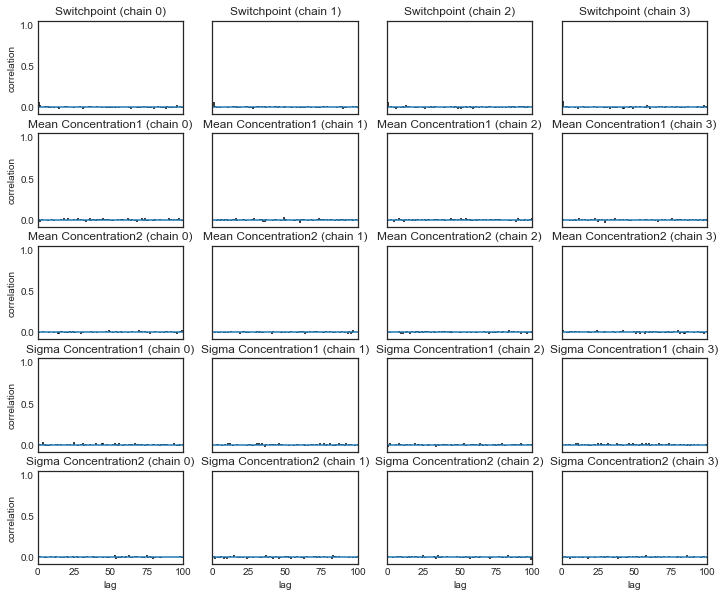

In [50]:
pm.plots.autocorrplot(Trace[50000::5])

In [51]:
pm.summary(Trace[50000::5])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Switchpoint,0.503825,0.499985,0.002603,0.000000,1.000000,34683.414630,0.999989
Mean Concentration1,0.067890,0.003865,0.000017,0.060258,0.075393,40191.414587,0.999967
Mean Concentration2,0.496976,0.287899,0.001568,0.029090,0.977747,39542.791888,0.999990
Sigma Concentration1,0.105883,0.002738,0.000014,0.100625,0.111388,40152.852730,0.999961
Sigma Concentration2,7.962475,6.012075,0.028235,0.000293,19.539005,39367.896023,0.999963


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1933d320>,
      dtype=object)

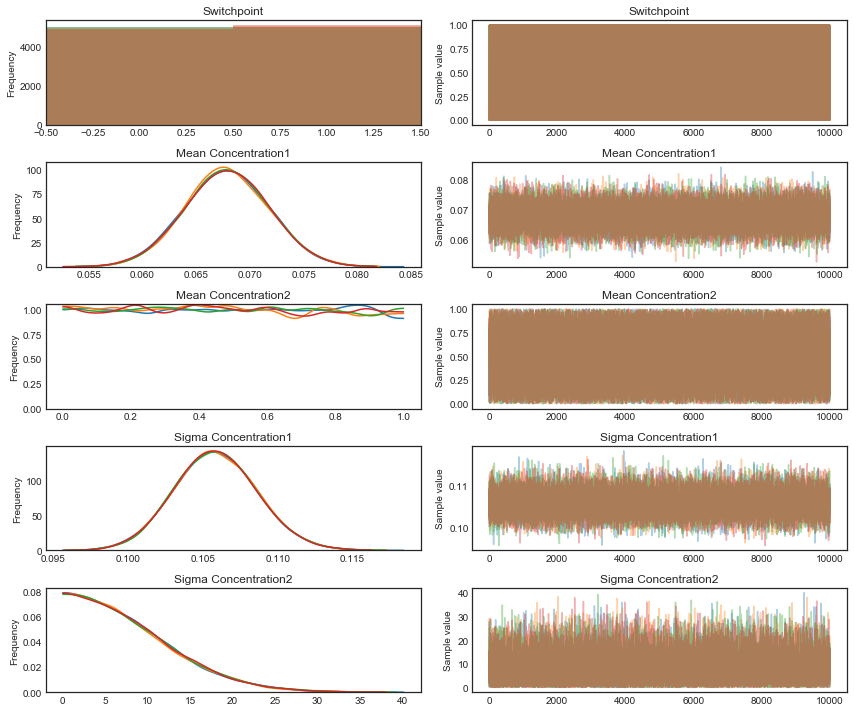

In [52]:
pm.traceplot(Trace[50000::5])

In [56]:
with pm.Model() as HypothesisTwo:
    Switchpoint1 = pm.DiscreteUniform('Switchpoint1', lower=0, upper=1, testval=.3)
    Switchpoint2 = pm.DiscreteUniform('Switchpoint2', lower=Switchpoint1, upper=1, testval=.5)
    
    Mean1 = pm.Uniform("Mean Concentration1", lower=0., upper=1., testval=.005)
    Mean2 = pm.Uniform("Mean Concentration2", lower=0., upper=1., testval=.02)
    Mean3 = pm.Uniform("Mean Concentration3", lower=0., upper=1., testval=.005)
    
    Sigma1 = pm.Exponential("Sigma Concentration1", .5)
    Sigma2 = pm.Exponential("Sigma Concentration2", .5)
    Sigma3 = pm.Exponential("Sigma Concentration3", .5)
    
    Mean_ = pm.math.switch(Switchpoint1 >= TimeIndex, Mean1, Mean2)
    Sigma_ = pm.math.switch(Switchpoint1 >= TimeIndex, Sigma1, Sigma2)
    
    Mean = pm.math.switch(Switchpoint2 >= TimeIndex, Mean_, Mean3)
    Sigma = pm.math.switch(Switchpoint2 >= TimeIndex, Sigma_, Sigma3)
    
    Likelihood = pm.Normal("Obs", mu=Mean, sd=Sigma, observed=Concentrations)


In [57]:
print(Model.logp(Model.test_point))
for RV in Model.basic_RVs:
    print(RV.name, RV.logp(Model.test_point))


-13292.967115900692
Probability_stickbreaking__ -4.484745839164019
GaussianMeans -9.664570878596155
Sigmas_log__ -2.3096777744197365
Obs -13276.508121408513


In [58]:
with HypothesisTwo:
    Trace = pm.sample(100000, cores = 4, progressbar=True, njobs = 2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [Switchpoint2]
>>Metropolis: [Switchpoint1]
>NUTS: [Sigma Concentration3_log__, Sigma Concentration2_log__, Sigma Concentration1_log__, Mean Concentration3_interval__, Mean Concentration2_interval__, Mean Concentration1_interval__]
100%|██████████| 100500/100500 [04:12<00:00, 397.73it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c149bd828>,
      dtype=object)

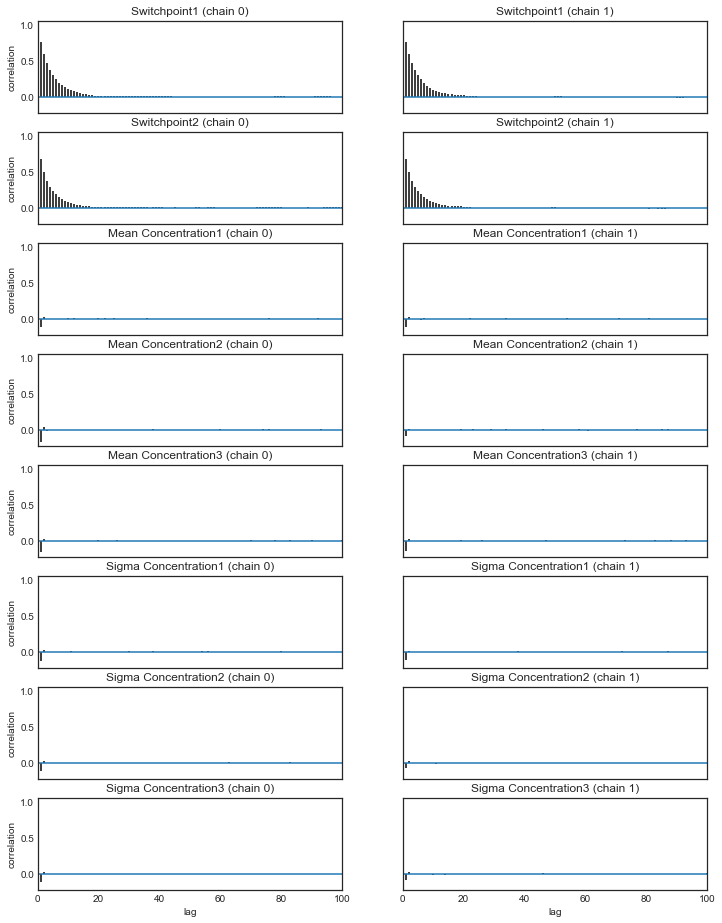

In [59]:
pm.autocorrplot(Trace)

NameError: name 'pm' is not defined